<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [102]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

In [ ]:
nlp = spacy.load("en_core_web_lg")

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [2]:
##### Your Code Here #####
raise Exception("Web Scraping of Indeed's website is against the terms of use according to cody")

Exception: Web Scraping of Indeed's website is against the terms of use

## 2) Use Spacy to tokenize / clean the listings 

In [3]:
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [161]:
##### Your Code Here #####
data = pd.read_csv('./data/job_listings.csv')
data = data.drop('Unnamed: 0', axis=1)
data['description'] = data['description'].apply(lambda x : re.sub(re.compile('<.*?>'), ' ', x))
data['description'] = data['description'].apply(lambda x : x.replace('\\n',' '))
data['description'] = data['description'].apply(lambda x : x.strip())
data['description'] = data['description'].apply(lambda x : x.split('b',maxsplit=1)[1])
st1 = '___________________________________________________________________________________'
data['description'] = data['description'].apply(lambda x : x.replace(st1,' '))
data['description'] = data['description'].apply(lambda x : x.replace('\\xe2\\x80\\xa6',' '))
data['description'] = data['description'].apply(lambda x : x.replace('\\xe2\\x80\\x99',' '))

In [183]:
data['description'][3]

"'   $4,969 - $6,756 a month   Contract   Under the general supervision of Professors Dana Mukamel and Kai Zheng, the incumbent will join the CalMHSA Mental Health Tech Suite Innovation (INN) Evaluation Team. This large, statewide multi-year study will evaluate the effectiveness of two new and innovative applications offered to people with mental health conditions, which include opportunities for online chatting between users and online listeners Responsibilities of the incumbent will include managing and analyzing text data created by users of the two mental health applications as part of the research and evaluation objectives of the team. The incumbent will collaborate with faculty and other team researchers, and will be expected to create under supervision and direction variables describing the usage of the apps, the interactions between users, and the effectiveness of the apps. The incumbent will also be expected to interact with the vendors of the apps around data issues.    The U

In [133]:
data.head()

,description,title
0,""" Job Requirements: Conceptual understand...",Data scientist
1,"' Job Description As a Data Scientist 1, y...",Data Scientist I
2,' As a Data Scientist you will be working on ...,Data Scientist - Entry Level
3,"' $4,969 - $6,756 a month Contract Under...",Data Scientist
4,' Location: USA \xe2\x80\x93 multiple locatio...,Data Scientist


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [134]:
##### Your Code Here #####
vect = CountVectorizer(stop_words='english')

data0 = data['description'].tolist()

vect.fit(data0)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [135]:
dtm = vect.transform(data0)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [136]:
dtm.head()

,00,000,02115,03,0305,0356,04,057,062,06366,...,zero,zeus,zf,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

C:\Users\Dylan Nason\Anaconda3\envs\U4-S1-NLP\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


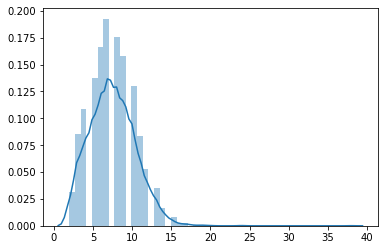

In [137]:
##### Your Code Here #####
import seaborn as sns

doc_len = [len(doc) for doc in dtm]

sns.distplot(doc_len);

In [138]:
docs = [(len(doc),name) for doc,name in zip(dtm,dtm.columns)]
docs.sort(reverse=True)
docs = docs[:10]

In [139]:
docs

[(38, 'ofccp_eeo_supplement_final_jrf_qa_508c'),
 (24, 'us_employment_compliance'),
 (24, 'disability_accommodation'),
 (20, 'undergradinternships'),
 (20, 'onlineaccommodations'),
 (19, 'x94cryptocurrencies'),
 (19, 'utilizingapplicable'),
 (19, 'qualificationsbasic'),
 (19, 'environmentadvanced'),
 (19, 'counterintelligence')]

In [140]:
dicter = {}
values = []
for x,xs in zip(docs,range(0,len(docs))):
    dicter[x[1]] = xs
    values.append(x[0])

In [141]:
values[0]

38

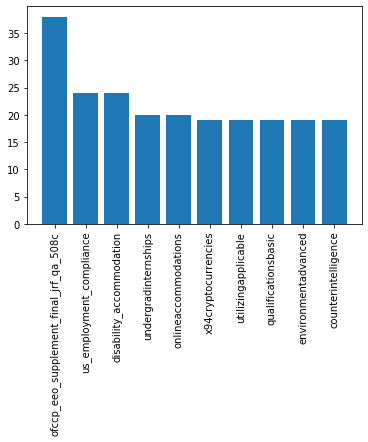

In [142]:
p1 = plt.bar(x=list(dicter.values()), height= values)
plt.xticks(list(dicter.values()), list(dicter.keys()), rotation=90)

plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [144]:
##### Your Code Here #####
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data0) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,,$,0,1,10,100,1079302,11,2,20,...,york,york city,york office,you\'ll,you\'ll,you\'ll work,you\'re,yrs,|,||
0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00000,0.0,0.040493,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.06605,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.13318,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [186]:
##### Your Code Here #####
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [149]:
nn.kneighbors([dtm.iloc[0]])

(array([[0.        , 1.30972714, 1.32283621, 1.32809104, 1.33132649]]),
 array([[  0, 115, 274, 366, 336]], dtype=int64))

In [163]:
data0[0][:300]

'"  Job Requirements:     Conceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them     Intermediate to expert level coding skills '

In [184]:
data0[115][:300]

"'   Company Overview    At Proofpoint, we have a passion for protecting people, data, and brands from today s advanced threats and compliance risks. We hire the best people in the business to:    Build and enhance our proven security platform   Blend innovation and speed in a constantly evolving clo"

In [172]:
target_job = """This job offers a lot of money specifically tailored to lambda school graduates.
I mean like 250k+ per year and it will have people that are capable of completing their work
and will perform above and beyond when asked. Also performance based bonuses and other bonuses
based on the quality of work / commitment to work, such as staying late or coming in early, as
that just makes sense.
"""

In [180]:
target_job = target_job.replace('\n',' ')
string = tfidf.transform([target_job])
nn.kneighbors(string.todense())

(array([[1.33521358, 1.35005768, 1.35209506, 1.3596289 , 1.3596289 ]]),
 array([[287, 309, 244, 123,  23]], dtype=int64))

In [185]:
data0[287]

'":Who We Are: SixLeaf is THE leading marketing platform for third party sellers on Amazon.com as well as a variety of other marketplaces. We offer a suite of complete software solutions for brands, both big and small, selling online. These solutions significantly improve marketplace performance and profit for our clients.  Our mission is to help as many brands as possible scale to the point where they are household names. And our goal is to be the very best at it. By helping quality brands grow, not only can we assist our clients to achieve their dreams, but we make the market a better place for consumers. Each member of our team shares in the joy and responsibility of making the ecommerce world a better place.    : What We Are Looking For: Do you love data? Do you love to experiment? Do you love FACTS?  SixLeaf is looking for someone who is passionate about these things. Someone who, with the fervor of an investigative reporter, wants to get to the inner workings of a thing. Someone 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 